In [6]:
# Import packages
import os
import optuna
from graphviz import Digraph
from optuna.storages import JournalFileStorage, JournalStorage
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np

In [7]:
num_nodes = 3
study_name = f"dcl_{num_nodes}"
optuna_dir = f"optuna/{study_name}"
# 表示設定
trial_state = "COMPLETE"  # または "RUNNING"
rankdir = "TB"  # "TB" = 縦, "LR" = 横

storage = JournalStorage(JournalFileStorage(os.path.join(optuna_dir, "optuna.log")))
study = optuna.create_study(
    storage=storage,
    study_name=study_name,
    load_if_exists=True,
)

/tmp/ipykernel_1069280/1936824331.py:8: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = JournalStorage(JournalFileStorage(os.path.join(optuna_dir, "optuna.log")))
[I 2025-08-14 11:54:44,157] Using an existing study with name 'dcl_3' instead of creating a new one.


In [8]:
def get_sorted_trials(study, state):
    df = study.trials_dataframe()
    df = df[df.state == state]
    return df.sort_values(by="value", ascending=False)


sorted_df = get_sorted_trials(study, trial_state)

In [9]:
def extract_scalar_arrays(scalar_events):
    wall_times = []
    steps = []
    values = []

    for event in scalar_events:
        wall_times.append(event.wall_time)
        steps.append(event.step)
        values.append(event.value)

    return np.array(wall_times), np.array(steps), np.array(values)


def get_model_names_for_trial(top_series, num_nodes):
    trial_dir = f"runs/{study_name}/{top_series.number:04}"
    model_names = [""] * num_nodes
    try:
        subdirs = sorted(os.listdir(trial_dir))
    except FileNotFoundError:
        subdirs = []
    for name in subdirs:
        if "_" not in name:
            continue
        prefix, model = name.split("_", 1)
        if prefix.isdigit():
            idx = int(prefix)
            if 0 <= idx < num_nodes:
                model_names[idx] = model
    # 補完: ノード1以降はOptunaのパラメータからも取得を試みる
    for i in range(1, num_nodes):
        if not model_names[i]:
            param_key = f"params_{i}_model"
            if param_key in top_series and isinstance(top_series[param_key], str):
                model_names[i] = top_series[param_key]
    # ノード0が未確定ならプレースホルダ
    if not model_names[0]:
        model_names[0] = "model0"
    return model_names


def get_node_label(top_series, model_id, model_names):
    # runs/dcl_{num_nodes}/{trial:04}/{i}_{model}
    node_label = f"{model_id+1}. {model_names[model_id]}"
    try:
        accumulator = EventAccumulator(
            f"runs/{study_name}/{top_series.number:04}/{model_id}_{model_names[model_id]}/"
        )
        accumulator.Reload()
        best_value = None
        try:
            scalar_tags = set(accumulator.Tags().get("scalars", []))
        except Exception:
            scalar_tags = set()
        # test_score のみを参照
        if "test_score" in scalar_tags:
            _, _, values = extract_scalar_arrays(accumulator.Scalars("test_score"))
            if len(values) > 0:
                best_value = max(values)
        if best_value is not None:
            node_label += f"\n{best_value:.2f}%"
    except Exception:
        pass
    return node_label


def get_edge_color(gate_name):
    # gate に基づく配色（明示色）
    return {
        "ThroughGate": "purple",  # 指定: 紫
        "PositiveLinearGate": "green",  # 指定: 緑
        "NegativeLinearGate": "blue",
    }.get(gate_name, "gray50")


def create_graph_for_trial(top_series, num_nodes, rankdir="LR"):
    model_names = get_model_names_for_trial(top_series, num_nodes)

    graph = Digraph(format="svg")
    graph.attr(rankdir=rankdir)

    # ラベル（教師信号）ノード
    image_node_id = "image"
    image_display = "Image"
    graph.node(image_node_id, label=image_display, shape="plaintext", fontcolor="black")

    for i in range(num_nodes):
        node_color = "pink" if i == 0 else "gray90"
        node_id = f"node_{i}"
        node_label = get_node_label(top_series, i, model_names)
        graph.node(
            node_id,
            label=node_label,
            color=node_color,
            fillcolor=node_color,
            style="filled",
        )

        # エッジ（教師信号: Label -> i）。自己ゲート params_{i}_{i}_gate を表示・配色
        gate_name_label = top_series[f"params_{i}_{i}_gate"]
        if gate_name_label != "CutoffGate":
            edge_color_label = get_edge_color(gate_name_label)
            graph.edge(
                image_node_id,
                node_id,
                label=gate_name_label.replace("Gate", ""),
                fontsize="13",
                fontcolor=edge_color_label,
                color=edge_color_label,
            )

        # エッジ（j -> i）
        for j in range(num_nodes):
            if j == i:
                continue
            gate_name = top_series[f"params_{i}_{j}_gate"]
            if gate_name == "CutoffGate":
                continue
            neighbor_node_id = f"node_{j}"
            edge_color = get_edge_color(gate_name)
            graph.edge(
                neighbor_node_id,
                node_id,
                label=gate_name.replace("Gate", ""),
                fontsize="13",
                fontcolor=edge_color,
                color=edge_color,
            )

        # 受け取り側の全入力（Label含む）がCutoffなら淡色でハイライト（学習済みモデル使用の視覚化）
        incoming_all = [top_series[f"params_{i}_{j}_gate"] for j in range(num_nodes)]
        if len(incoming_all) > 0 and all(g == "CutoffGate" for g in incoming_all):
            graph.node(
                node_id,
                label=node_label,
                color="lightblue",
                fillcolor="lightblue",
                style="radial",
            )
    return graph

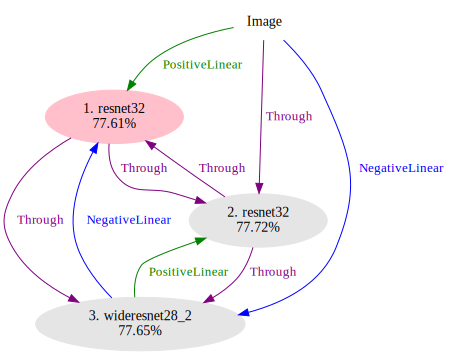

In [10]:
top = 0
if len(sorted_df) == 0:
    raise ValueError(f"No trials with state={trial_state}")
G = create_graph_for_trial(sorted_df.iloc[top], num_nodes, rankdir=rankdir)
display(G)